## Assignment 3

In this task we implement a simple single hidden layer neural networks with logistic regression classifier on CIFAR10 dataset. Our implementation consists of 2 main class:

    MLP

    Contains implementation of multilayer perceptron. NUmber of hidden layers specified by user. 

    ModelEvaluator

    Class consisting of basic functionalities for training, testing and visualizing loss. 
    Additionally, implements Hinge Loss and Softmax loss without torch.nn.


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle as skshuffle
import numpy as np
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt



In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
class MLP(torch.nn.Module):
    def __init__(self, n_in, n_hidden, drop_p, n_out, act):
        super(MLP, self).__init__()
        '''
        n_in: Number of Inputs
        n_hidden: List with units in hidden layers
        n_out: Number of Output Units
        '''
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        self.p = drop_p
        self.input_layer = nn.Linear(self.n_in, self.n_hidden[0])
        if act =='relu':
            self.nonlin = nn.ReLU()
        elif act =='tanh':
            self.nonlin = nn.Tanh()
        elif act=='sigmoid':
            self.nonlin = nn.Sigmoid()
        self.hidden = nn.ModuleList()
        self.loss = nn.CrossEntropyLoss()
        
        for i in range(len(self.n_hidden)-1):
            self.hidden.append(nn.Linear(self.n_hidden[i], self.n_hidden[i+1]))
            self.hidden.append(self.nonlin) 
            self.hidden.append(nn.Dropout(p = self.p))
        self.final_fc = nn.Linear(self.n_hidden[-1], self.n_out)


    def forward(self, X):
        '''
        forward pass
        '''
        X = self.nonlin(self.input_layer(X))
        for layer in self.hidden:
            X = layer(X)
        return X

Basic functionalities for evaluating model alongwith implementation of hinge and softmax loss.

In [0]:
class ModelEvaluator:
    def __init__(self, model, epochs, lr, loss_type='softmax', l2=0.0, use_gpu=False, optim='adam'):
        '''
        model: instance of pytorch model class
        epochs: number of training epochs
        lr: learning rate
        use_gpu: to use gpu
        optim: optimizer used for training, SGD or adam
        '''
        self.epochs = epochs
        self.lr = lr
        self.model = model
        self.loss_type = loss_type
        self.l2 = l2
        self.use_gpu = use_gpu
        self.train_loss = []
        self.test_loss = []

        if self.use_gpu:
            self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

            if self.device == 'cuda:0':
                if torch.cuda.device_count()>1:
                    self.model = nn.DataParallel(model)
                self.model.to(device)

        if optim=='adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        elif optim=='sgd':
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr = lr, momentum=0.9)
        elif optim=='adadelta':
            self.optimizer = torch.optim.Adadelta(self.model.parameters(), lr = lr, eps=1e-6, weight_decay=0)
        elif optim=='adagrad':
            self.optimizer = torch.optim.Adagrad(self.model.parameters(), lr = lr, lr_decay=1e-6, weight_decay=0)
        elif optim=='rmsprop':
            self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr = lr, alpha=0.995, eps=1e-7, weight_decay=0)
        else:
            ValueError('Optimizer Not Supported')

    def softmax_loss(self, scores, y_label):
        '''
        softmax loss without torch.nn
        '''
        exp_scores = torch.exp(scores - torch.max(scores, dim=1)[0].view(-1,1))
        sum_exp_scores = exp_scores.sum(dim=1).view(-1,1)
        softmax_prob = exp_scores/sum_exp_scores
        loss = -torch.log(softmax_prob[np.arange(len(scores)), y_label])
        loss = loss.sum()
        return loss

    def hinge_loss(self, scores, y_label):
        '''
        hinge loss for multiclass without torch.nn
        '''
        hinge_loss = torch.clamp(scores - scores[np.arange(len(scores)),y_label].view(-1,1) + 1, min=0)
        hinge_loss[np.arange(len(scores)),y_label] = 0
        hinge_loss = hinge_loss.sum()

        return hinge_loss

    def l2_regularization(self, loss, lam):
        l2 = 0
        for W in self.model.parameters():
            l2 += W.norm(2)#pow(2).sum().sqrt()
        loss = loss + 0.5*lam*l2
        return loss	


    def train(self, epoch, trainloader, print_every=100):
        '''
        method for training
        '''
        loss_batch = 0
        for b_idx, (train_data, train_labels) in enumerate(trainloader):
            if self.use_gpu and self.device == 'cuda:0':
                train_data, train_labels = train_data.to(self.device), train_labels.to(self.device)
            train_data = train_data.reshape(-1, 32*32*3)

            # Scale Images
            train_data = train_data / 255

            # Forward Pass 
            train_preds = self.model.forward(train_data)
            if self.loss_type=='nn_ce':
                loss = self.model.loss(train_preds, train_labels)
            elif self.loss_type=='softmax':
                loss = self.softmax_loss(train_preds, train_labels)
            elif self.loss_type =='hinge':
                loss = self.hinge_loss(train_preds, train_labels)
            else:
                ValueError('Loss Not Supported')
            if self.l2:
                loss = self.l2_regularization(loss, self.l2)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if b_idx%print_every == 0:
                print('Train Epoch: {0} [{1}/{2} ({3:.0f}%)]\t Loss {4:.6f}'.
                    format(epoch, b_idx*len(train_data), len(trainloader.dataset), 
                        100.*b_idx/len(trainloader), loss))

            loss_batch += loss
        loss_batch /= len(trainloader)
        self.train_loss.append(loss_batch)    

    def validation(self, valloader):
        '''
        method for testing
        '''
        correct_, total_ = 0, 0
        with torch.no_grad():
            loss = 0
            for val_data, val_labels in valloader:
                if self.use_gpu and self.device == 'cuda:0':
                    val_data, val_labels = test_data.to(self.device), val_labels.to(self.device)
                val_data = val_data.reshape(-1, 32*32*3)
                val_data = val_data / 255
                val_preds = self.model.forward(val_data)
                if self.loss_type=='nn_ce':
                    loss += self.model.loss(val_preds, val_labels)                    
                elif self.loss_type=='softmax':
                    loss += self.softmax_loss(val_preds, val_labels)
                elif self.loss_type =='hinge':
                    loss += self.hinge_loss(val_preds, val_labels)
                else:
                    ValueError('Loss Not Supported')

                _, val_pred_labels = torch.max(val_preds.data, 1)
                total_ += val_labels.size(0)
                correct_ += (val_pred_labels.cpu() == val_labels.cpu()).sum()

            loss /= len(valloader)
            self.val_loss.append(loss)
            accuracy_val = (100.0*correct_/total_)
            print('Validation Loss {1:.2f} Accuracy on validation set {2:.2f}'.format(loss, accuracy_val))
            return accuracy_val

    def test(self, testloader):
        '''
        method for testing
        '''
        correct_, total_ = 0, 0
        with torch.no_grad():
            loss = 0
            for test_data, test_labels in testloader:
                if self.use_gpu and self.device == 'cuda:0':
                    test_data, test_labels = test_data.to(self.device), test_labels.to(self.device)
                test_data = test_data.reshape(-1, 32*32*3)
                test_data = test_data / 255
                test_preds = self.model.forward(test_data)

                if self.loss_type=='nn_ce':
                    loss += self.model.loss(test_preds, test_labels)
                if self.loss_type=='softmax':
                    loss += self.softmax_loss(test_preds, test_labels)
                elif self.loss_type =='hinge':
                    loss += self.hinge_loss(test_preds, test_labels)
                else:
                    ValueError('Loss Not Supported')

                _, test_pred_labels = torch.max(test_preds.data, 1)
                total_ += test_labels.size(0)
                correct_ += (test_pred_labels.cpu() == test_labels.cpu()).sum()

            loss /= len(testloader)
            self.test_loss.append(loss)
            accuracy_test = (100*correct_/total_)
            print('Accuracy of model on test set {0:.2f}'.format(accuracy_test))
            return accuracy_test

    def evaluator(self, trainloader, testloader, print_every=1000, validation=False):
        for epoch in range(self.epochs):
            self.train(epoch, trainloader, print_every=print_every)
            if validation:
                acc_ = self.validation(testloader)
            else:
                acc_ = self.test(testloader)
        return acc_
    def plot_loss(self, validation=False):
        '''
        to visualize loss
        '''
        plt.plot(range(len(self.train_loss)), self.train_loss, label='Training Loss')
        if validation:
            plt.plot(range(len(self.val_loss)), self.val_loss, label='Validation Loss')
        else:
            plt.plot(range(len(self.test_loss)), self.test_loss, label='Testing Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [0]:
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Parameters
n_in = np.prod(trainset[0][0].numpy().shape)
n_out = len(classes)
batch_size = 100

Files already downloaded and verified


In [0]:
# Hyperparameters
lr = 0.001
epochs = 50
# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

## Cross Entropy Loss

In [0]:
# Model
n_hidden = [1024, 512]
l2 = 0.0
drop_p = 0.5
# Pytorch Cross Entropy Loss
loss_type = 'nn_ce'
act = 'relu'
model = MLP(n_in, n_hidden, drop_p, n_out, act)
modeleval = ModelEvaluator(model, epochs, lr, loss_type=loss_type, l2=l2, use_gpu=True)
modeleval.evaluator(trainloader, testloader, print_every=100, validation=False)

Train Epoch: 0 [0/50000 (0%)]	 Loss 6.232867
Train Epoch: 0 [10000/50000 (20%)]	 Loss 5.382292
Train Epoch: 0 [20000/50000 (40%)]	 Loss 5.277403
Train Epoch: 0 [30000/50000 (60%)]	 Loss 5.185946
Train Epoch: 0 [40000/50000 (80%)]	 Loss 5.236453
Accuracy of model on test set 16.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 5.205876
Train Epoch: 1 [10000/50000 (20%)]	 Loss 5.112244
Train Epoch: 1 [20000/50000 (40%)]	 Loss 5.382571
Train Epoch: 1 [30000/50000 (60%)]	 Loss 5.150347
Train Epoch: 1 [40000/50000 (80%)]	 Loss 5.166246
Accuracy of model on test set 17.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 5.150881
Train Epoch: 2 [10000/50000 (20%)]	 Loss 5.260643
Train Epoch: 2 [20000/50000 (40%)]	 Loss 5.494028
Train Epoch: 2 [30000/50000 (60%)]	 Loss 5.313973
Train Epoch: 2 [40000/50000 (80%)]	 Loss 5.025365
Accuracy of model on test set 18.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 5.132894
Train Epoch: 3 [10000/50000 (20%)]	 Loss 5.538060
Train Epoch: 3 [20000/50000 (40%)]	 Loss 5.031598
Train Epoch:

tensor(21)

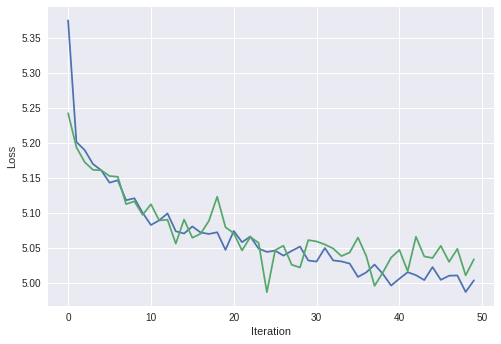

In [0]:
modeleval.plot_loss()

## Softmax Loss

In [0]:
# Model
n_hidden = [1024, 512, 256]
l2 = 0.0
drop_p = 0.3
loss_type = 'softmax'
act = 'relu'
model = MLP(n_in, n_hidden, drop_p, n_out, act)
modeleval = ModelEvaluator(model, epochs, lr, loss_type=loss_type, l2=l2, use_gpu=True)
modeleval.evaluator(trainloader, testloader, print_every=100, validation=False)

Train Epoch: 0 [0/50000 (0%)]	 Loss 554.218689
Train Epoch: 0 [10000/50000 (20%)]	 Loss 438.837585
Train Epoch: 0 [20000/50000 (40%)]	 Loss 464.065460
Train Epoch: 0 [30000/50000 (60%)]	 Loss 434.175293
Train Epoch: 0 [40000/50000 (80%)]	 Loss 441.480255
Accuracy of model on test set 16.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 412.809052
Train Epoch: 1 [10000/50000 (20%)]	 Loss 424.599548
Train Epoch: 1 [20000/50000 (40%)]	 Loss 416.200043
Train Epoch: 1 [30000/50000 (60%)]	 Loss 407.702240
Train Epoch: 1 [40000/50000 (80%)]	 Loss 432.096771
Accuracy of model on test set 19.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 433.702423
Train Epoch: 2 [10000/50000 (20%)]	 Loss 426.021027
Train Epoch: 2 [20000/50000 (40%)]	 Loss 423.792999
Train Epoch: 2 [30000/50000 (60%)]	 Loss 377.080627
Train Epoch: 2 [40000/50000 (80%)]	 Loss 378.373108
Accuracy of model on test set 22.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 404.745331
Train Epoch: 3 [10000/50000 (20%)]	 Loss 411.078613
Train Epoch: 3 [20000/50000 

tensor(32)

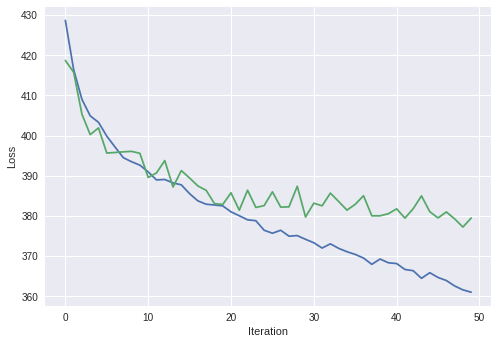

In [0]:
modeleval.plot_loss()

## Hinge Loss

In [0]:
# Model
n_hidden = [1024, 512, 256, 128]
l2 = 0.0
drop_p = 0.4
loss_type = 'hinge'
act = 'relu'
model = MLP(n_in, n_hidden, drop_p, n_out, act)
modeleval = ModelEvaluator(model, epochs, lr, loss_type=loss_type, l2=l2, use_gpu=True)
modeleval.evaluator(trainloader, testloader, print_every=100, validation=False)

Train Epoch: 0 [0/50000 (0%)]	 Loss 12621.341797
Train Epoch: 0 [10000/50000 (20%)]	 Loss 5817.523438
Train Epoch: 0 [20000/50000 (40%)]	 Loss 6802.887695
Train Epoch: 0 [30000/50000 (60%)]	 Loss 6823.408691
Train Epoch: 0 [40000/50000 (80%)]	 Loss 6774.600586
Accuracy of model on test set 10.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 6385.797852
Train Epoch: 1 [10000/50000 (20%)]	 Loss 6919.038086
Train Epoch: 1 [20000/50000 (40%)]	 Loss 6147.621094
Train Epoch: 1 [30000/50000 (60%)]	 Loss 7615.387695
Train Epoch: 1 [40000/50000 (80%)]	 Loss 5969.244141
Accuracy of model on test set 17.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 5853.657227
Train Epoch: 2 [10000/50000 (20%)]	 Loss 6238.580078
Train Epoch: 2 [20000/50000 (40%)]	 Loss 6802.167969
Train Epoch: 2 [30000/50000 (60%)]	 Loss 5739.160645
Train Epoch: 2 [40000/50000 (80%)]	 Loss 5853.287109
Accuracy of model on test set 17.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 5245.304199
Train Epoch: 3 [10000/50000 (20%)]	 Loss 5480.040039
Train Epoc

tensor(30)

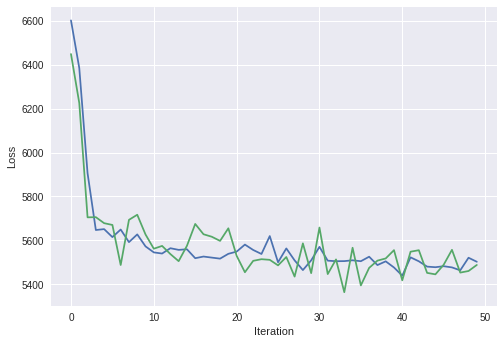

In [0]:
modeleval.plot_loss()

Here we experiment with different loss function, optimizers and nonlinearities.

    loss: softmax and hinge.
    
    optimizers: sgd, adagrad, adamax, adam, adadelta.
    
    nonlinearities: tanh, relu and sigmoid.
    

Train Epoch: 0 [0/50000 (0%)]	 Loss 624.488403
Train Epoch: 0 [10000/50000 (20%)]	 Loss 459.118896
Train Epoch: 0 [20000/50000 (40%)]	 Loss 437.848816
Train Epoch: 0 [30000/50000 (60%)]	 Loss 464.996307
Train Epoch: 0 [40000/50000 (80%)]	 Loss 460.380615
Accuracy of model on test set 10.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 461.835083
Train Epoch: 1 [10000/50000 (20%)]	 Loss 443.169586
Train Epoch: 1 [20000/50000 (40%)]	 Loss 454.933136
Train Epoch: 1 [30000/50000 (60%)]	 Loss 458.376038
Train Epoch: 1 [40000/50000 (80%)]	 Loss 460.370148
Accuracy of model on test set 9.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 456.666412
Train Epoch: 2 [10000/50000 (20%)]	 Loss 459.529816
Train Epoch: 2 [20000/50000 (40%)]	 Loss 457.531372
Train Epoch: 2 [30000/50000 (60%)]	 Loss 467.174591
Train Epoch: 2 [40000/50000 (80%)]	 Loss 468.046570
Accuracy of model on test set 10.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 452.972382
Train Epoch: 3 [10000/50000 (20%)]	 Loss 464.129425
Train Epoch: 3 [20000/50000 (

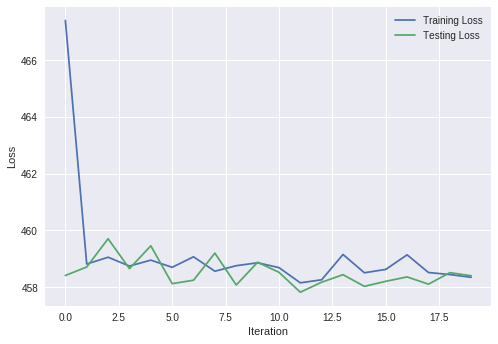

train_test_loss_losstype: softmax, optimsgd, non_lintanh
Train Epoch: 0 [0/50000 (0%)]	 Loss 623.801514
Train Epoch: 0 [10000/50000 (20%)]	 Loss 415.244385
Train Epoch: 0 [20000/50000 (40%)]	 Loss 394.196503
Train Epoch: 0 [30000/50000 (60%)]	 Loss 393.842987
Train Epoch: 0 [40000/50000 (80%)]	 Loss 419.974426
Accuracy of model on test set 11.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 353.623596
Train Epoch: 1 [10000/50000 (20%)]	 Loss 412.190765
Train Epoch: 1 [20000/50000 (40%)]	 Loss 410.106415
Train Epoch: 1 [30000/50000 (60%)]	 Loss 398.251587
Train Epoch: 1 [40000/50000 (80%)]	 Loss 376.618713
Accuracy of model on test set 12.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 422.769653
Train Epoch: 2 [10000/50000 (20%)]	 Loss 393.899536
Train Epoch: 2 [20000/50000 (40%)]	 Loss 407.249603
Train Epoch: 2 [30000/50000 (60%)]	 Loss 391.175110
Train Epoch: 2 [40000/50000 (80%)]	 Loss 424.647247
Accuracy of model on test set 15.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 383.803314
Train Epoch: 3 [10000/5

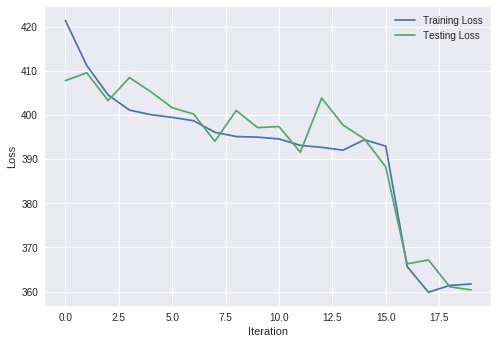

train_test_loss_losstype: softmax, optimsgd, non_linrelu
Train Epoch: 0 [0/50000 (0%)]	 Loss 624.060120
Train Epoch: 0 [10000/50000 (20%)]	 Loss 534.058167
Train Epoch: 0 [20000/50000 (40%)]	 Loss 526.004944
Train Epoch: 0 [30000/50000 (60%)]	 Loss 521.489624
Train Epoch: 0 [40000/50000 (80%)]	 Loss 531.402222
Accuracy of model on test set 10.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 527.164307
Train Epoch: 1 [10000/50000 (20%)]	 Loss 522.539795
Train Epoch: 1 [20000/50000 (40%)]	 Loss 512.711548
Train Epoch: 1 [30000/50000 (60%)]	 Loss 531.116211
Train Epoch: 1 [40000/50000 (80%)]	 Loss 529.618042
Accuracy of model on test set 10.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 528.254517
Train Epoch: 2 [10000/50000 (20%)]	 Loss 528.166321
Train Epoch: 2 [20000/50000 (40%)]	 Loss 545.378601
Train Epoch: 2 [30000/50000 (60%)]	 Loss 519.733887
Train Epoch: 2 [40000/50000 (80%)]	 Loss 533.826538
Accuracy of model on test set 10.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 519.645386
Train Epoch: 3 [10000/5

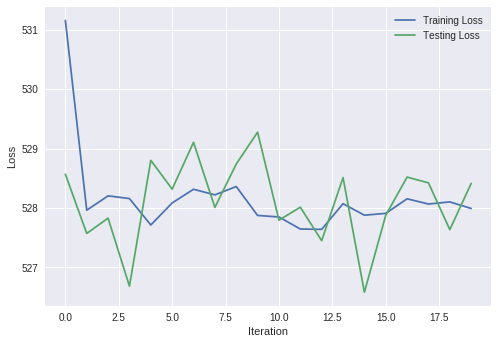

train_test_loss_losstype: softmax, optimsgd, non_linsigmoid
Train Epoch: 0 [0/50000 (0%)]	 Loss 624.088074
Train Epoch: 0 [10000/50000 (20%)]	 Loss 462.690491
Train Epoch: 0 [20000/50000 (40%)]	 Loss 455.609283
Train Epoch: 0 [30000/50000 (60%)]	 Loss 453.225372
Train Epoch: 0 [40000/50000 (80%)]	 Loss 454.678650
Accuracy of model on test set 11.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 466.998169
Train Epoch: 1 [10000/50000 (20%)]	 Loss 460.337128
Train Epoch: 1 [20000/50000 (40%)]	 Loss 450.397858
Train Epoch: 1 [30000/50000 (60%)]	 Loss 453.416931
Train Epoch: 1 [40000/50000 (80%)]	 Loss 461.229614
Accuracy of model on test set 12.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 458.543732
Train Epoch: 2 [10000/50000 (20%)]	 Loss 468.570221
Train Epoch: 2 [20000/50000 (40%)]	 Loss 460.196228
Train Epoch: 2 [30000/50000 (60%)]	 Loss 459.682556
Train Epoch: 2 [40000/50000 (80%)]	 Loss 466.495789
Accuracy of model on test set 10.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 460.418732
Train Epoch: 3 [1000

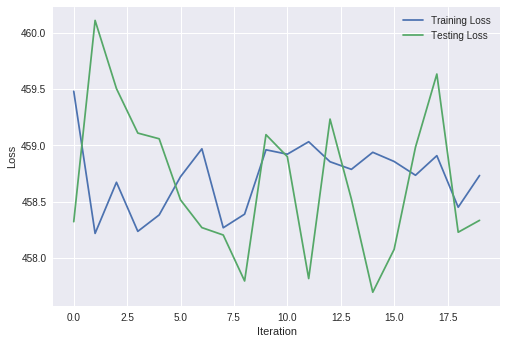

train_test_loss_losstype: softmax, optimrmsprop, non_lintanh
Train Epoch: 0 [0/50000 (0%)]	 Loss 624.335144
Train Epoch: 0 [10000/50000 (20%)]	 Loss 463.077972
Train Epoch: 0 [20000/50000 (40%)]	 Loss 485.990204
Train Epoch: 0 [30000/50000 (60%)]	 Loss 482.038269
Train Epoch: 0 [40000/50000 (80%)]	 Loss 492.576721
Accuracy of model on test set 21.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 496.100098
Train Epoch: 1 [10000/50000 (20%)]	 Loss 440.722748
Train Epoch: 1 [20000/50000 (40%)]	 Loss 449.568604
Train Epoch: 1 [30000/50000 (60%)]	 Loss 491.583313
Train Epoch: 1 [40000/50000 (80%)]	 Loss 401.710327
Accuracy of model on test set 21.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 481.120239
Train Epoch: 2 [10000/50000 (20%)]	 Loss 490.327820
Train Epoch: 2 [20000/50000 (40%)]	 Loss 446.037170
Train Epoch: 2 [30000/50000 (60%)]	 Loss 455.507355
Train Epoch: 2 [40000/50000 (80%)]	 Loss 455.230316
Accuracy of model on test set 22.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 531.848511
Train Epoch: 3 [100

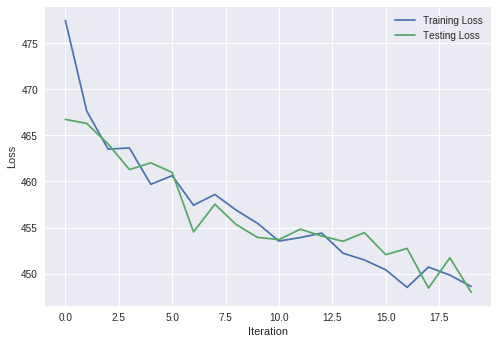

train_test_loss_losstype: softmax, optimrmsprop, non_linrelu
Train Epoch: 0 [0/50000 (0%)]	 Loss 628.263855
Train Epoch: 0 [10000/50000 (20%)]	 Loss 519.625732
Train Epoch: 0 [20000/50000 (40%)]	 Loss 520.903870
Train Epoch: 0 [30000/50000 (60%)]	 Loss 526.690125
Train Epoch: 0 [40000/50000 (80%)]	 Loss 529.496338
Accuracy of model on test set 11.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 546.566589
Train Epoch: 1 [10000/50000 (20%)]	 Loss 528.107178
Train Epoch: 1 [20000/50000 (40%)]	 Loss 532.350891
Train Epoch: 1 [30000/50000 (60%)]	 Loss 520.879822
Train Epoch: 1 [40000/50000 (80%)]	 Loss 523.838074
Accuracy of model on test set 11.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 516.677002
Train Epoch: 2 [10000/50000 (20%)]	 Loss 525.337463
Train Epoch: 2 [20000/50000 (40%)]	 Loss 519.616333
Train Epoch: 2 [30000/50000 (60%)]	 Loss 522.409119
Train Epoch: 2 [40000/50000 (80%)]	 Loss 526.670959
Accuracy of model on test set 11.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 530.962463
Train Epoch: 3 [100

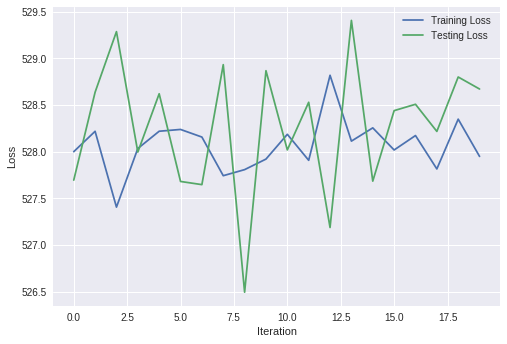

train_test_loss_losstype: softmax, optimrmsprop, non_linsigmoid
Train Epoch: 0 [0/50000 (0%)]	 Loss 622.555054
Train Epoch: 0 [10000/50000 (20%)]	 Loss 455.941650
Train Epoch: 0 [20000/50000 (40%)]	 Loss 444.662506
Train Epoch: 0 [30000/50000 (60%)]	 Loss 467.394531
Train Epoch: 0 [40000/50000 (80%)]	 Loss 455.707214
Accuracy of model on test set 10.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 452.531494
Train Epoch: 1 [10000/50000 (20%)]	 Loss 454.488129
Train Epoch: 1 [20000/50000 (40%)]	 Loss 465.386505
Train Epoch: 1 [30000/50000 (60%)]	 Loss 457.779938
Train Epoch: 1 [40000/50000 (80%)]	 Loss 451.178223
Accuracy of model on test set 11.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 461.703827
Train Epoch: 2 [10000/50000 (20%)]	 Loss 460.222412
Train Epoch: 2 [20000/50000 (40%)]	 Loss 460.293457
Train Epoch: 2 [30000/50000 (60%)]	 Loss 451.209320
Train Epoch: 2 [40000/50000 (80%)]	 Loss 447.083862
Accuracy of model on test set 12.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 465.520813
Train Epoch: 3 [

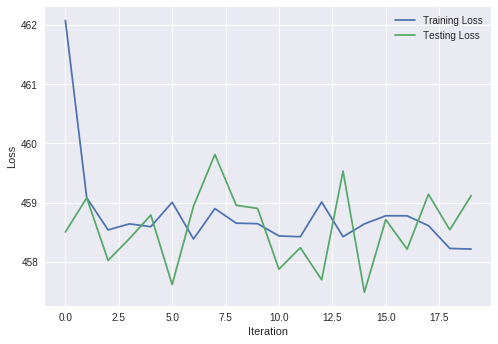

train_test_loss_losstype: softmax, optimadam, non_lintanh
Train Epoch: 0 [0/50000 (0%)]	 Loss 623.876343
Train Epoch: 0 [10000/50000 (20%)]	 Loss 510.823853
Train Epoch: 0 [20000/50000 (40%)]	 Loss 455.542297
Train Epoch: 0 [30000/50000 (60%)]	 Loss 492.072449
Train Epoch: 0 [40000/50000 (80%)]	 Loss 466.104095
Accuracy of model on test set 20.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 455.667786
Train Epoch: 1 [10000/50000 (20%)]	 Loss 475.159302
Train Epoch: 1 [20000/50000 (40%)]	 Loss 429.642426
Train Epoch: 1 [30000/50000 (60%)]	 Loss 455.802979
Train Epoch: 1 [40000/50000 (80%)]	 Loss 479.646637
Accuracy of model on test set 22.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 453.432373
Train Epoch: 2 [10000/50000 (20%)]	 Loss 421.732300
Train Epoch: 2 [20000/50000 (40%)]	 Loss 454.534424
Train Epoch: 2 [30000/50000 (60%)]	 Loss 425.306213
Train Epoch: 2 [40000/50000 (80%)]	 Loss 502.224274
Accuracy of model on test set 23.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 525.221741
Train Epoch: 3 [10000/

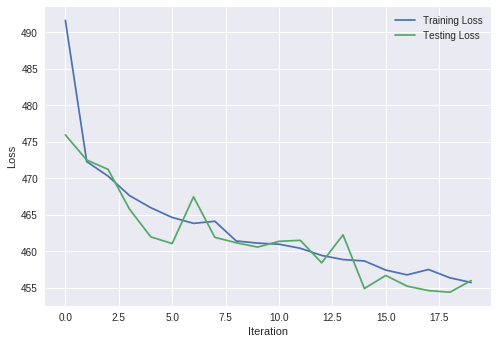

train_test_loss_losstype: softmax, optimadam, non_linrelu
Train Epoch: 0 [0/50000 (0%)]	 Loss 630.463928
Train Epoch: 0 [10000/50000 (20%)]	 Loss 523.827576
Train Epoch: 0 [20000/50000 (40%)]	 Loss 526.757202
Train Epoch: 0 [30000/50000 (60%)]	 Loss 533.757263
Train Epoch: 0 [40000/50000 (80%)]	 Loss 520.865723
Accuracy of model on test set 9.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 530.825500
Train Epoch: 1 [10000/50000 (20%)]	 Loss 528.174072
Train Epoch: 1 [20000/50000 (40%)]	 Loss 526.475281
Train Epoch: 1 [30000/50000 (60%)]	 Loss 525.206604
Train Epoch: 1 [40000/50000 (80%)]	 Loss 523.729980
Accuracy of model on test set 10.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 515.306030
Train Epoch: 2 [10000/50000 (20%)]	 Loss 538.149536
Train Epoch: 2 [20000/50000 (40%)]	 Loss 518.179565
Train Epoch: 2 [30000/50000 (60%)]	 Loss 533.732849
Train Epoch: 2 [40000/50000 (80%)]	 Loss 526.476868
Accuracy of model on test set 10.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 530.862671
Train Epoch: 3 [10000/5

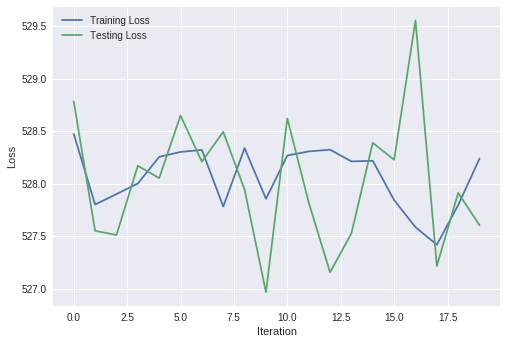

train_test_loss_losstype: softmax, optimadam, non_linsigmoid
Train Epoch: 0 [0/50000 (0%)]	 Loss 624.471863
Train Epoch: 0 [10000/50000 (20%)]	 Loss 470.704803
Train Epoch: 0 [20000/50000 (40%)]	 Loss 460.808228
Train Epoch: 0 [30000/50000 (60%)]	 Loss 458.590240
Train Epoch: 0 [40000/50000 (80%)]	 Loss 459.148315
Accuracy of model on test set 10.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 463.879303
Train Epoch: 1 [10000/50000 (20%)]	 Loss 470.527679
Train Epoch: 1 [20000/50000 (40%)]	 Loss 459.775970
Train Epoch: 1 [30000/50000 (60%)]	 Loss 459.014404
Train Epoch: 1 [40000/50000 (80%)]	 Loss 460.082397
Accuracy of model on test set 10.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 453.738312
Train Epoch: 2 [10000/50000 (20%)]	 Loss 470.376221
Train Epoch: 2 [20000/50000 (40%)]	 Loss 446.279144
Train Epoch: 2 [30000/50000 (60%)]	 Loss 458.128235
Train Epoch: 2 [40000/50000 (80%)]	 Loss 451.597076
Accuracy of model on test set 9.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 450.427979
Train Epoch: 3 [1000

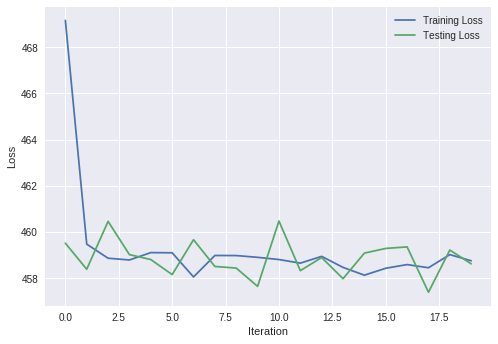

train_test_loss_losstype: softmax, optimadagrad, non_lintanh
Train Epoch: 0 [0/50000 (0%)]	 Loss 623.717041
Train Epoch: 0 [10000/50000 (20%)]	 Loss 531.932251
Train Epoch: 0 [20000/50000 (40%)]	 Loss 487.487244
Train Epoch: 0 [30000/50000 (60%)]	 Loss 513.468567
Train Epoch: 0 [40000/50000 (80%)]	 Loss 498.063843
Accuracy of model on test set 10.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 494.119171
Train Epoch: 1 [10000/50000 (20%)]	 Loss 497.928986
Train Epoch: 1 [20000/50000 (40%)]	 Loss 497.844910
Train Epoch: 1 [30000/50000 (60%)]	 Loss 508.715942
Train Epoch: 1 [40000/50000 (80%)]	 Loss 471.379608
Accuracy of model on test set 11.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 498.310333
Train Epoch: 2 [10000/50000 (20%)]	 Loss 496.092102
Train Epoch: 2 [20000/50000 (40%)]	 Loss 487.976379
Train Epoch: 2 [30000/50000 (60%)]	 Loss 498.819275
Train Epoch: 2 [40000/50000 (80%)]	 Loss 509.670288
Accuracy of model on test set 13.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 472.037384
Train Epoch: 3 [100

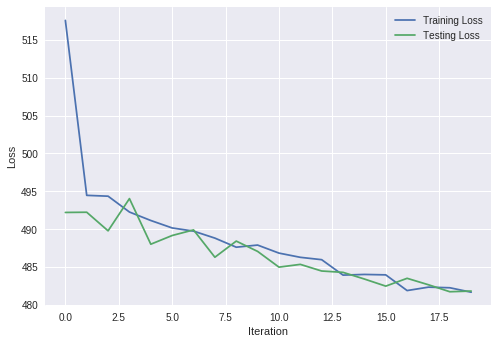

train_test_loss_losstype: softmax, optimadagrad, non_linrelu
Train Epoch: 0 [0/50000 (0%)]	 Loss 631.740112
Train Epoch: 0 [10000/50000 (20%)]	 Loss 538.762634
Train Epoch: 0 [20000/50000 (40%)]	 Loss 522.253418
Train Epoch: 0 [30000/50000 (60%)]	 Loss 533.119873
Train Epoch: 0 [40000/50000 (80%)]	 Loss 535.754150
Accuracy of model on test set 9.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 529.957153
Train Epoch: 1 [10000/50000 (20%)]	 Loss 527.014893
Train Epoch: 1 [20000/50000 (40%)]	 Loss 517.026123
Train Epoch: 1 [30000/50000 (60%)]	 Loss 528.214722
Train Epoch: 1 [40000/50000 (80%)]	 Loss 522.737732
Accuracy of model on test set 9.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 535.324951
Train Epoch: 2 [10000/50000 (20%)]	 Loss 538.284912
Train Epoch: 2 [20000/50000 (40%)]	 Loss 525.389160
Train Epoch: 2 [30000/50000 (60%)]	 Loss 531.038269
Train Epoch: 2 [40000/50000 (80%)]	 Loss 529.570007
Accuracy of model on test set 9.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 524.020752
Train Epoch: 3 [10000/

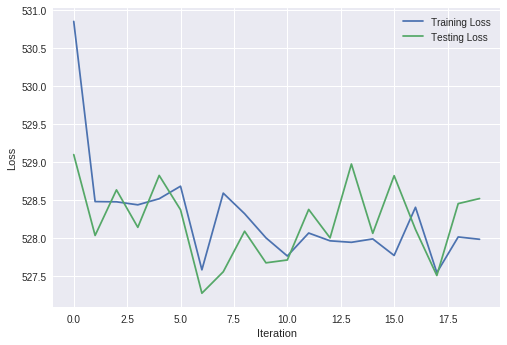

train_test_loss_losstype: softmax, optimadagrad, non_linsigmoid
Train Epoch: 0 [0/50000 (0%)]	 Loss 623.667297
Train Epoch: 0 [10000/50000 (20%)]	 Loss 622.713196
Train Epoch: 0 [20000/50000 (40%)]	 Loss 620.922485
Train Epoch: 0 [30000/50000 (60%)]	 Loss 619.606445
Train Epoch: 0 [40000/50000 (80%)]	 Loss 618.864563
Accuracy of model on test set 9.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 617.251038
Train Epoch: 1 [10000/50000 (20%)]	 Loss 615.340637
Train Epoch: 1 [20000/50000 (40%)]	 Loss 612.721008
Train Epoch: 1 [30000/50000 (60%)]	 Loss 610.845886
Train Epoch: 1 [40000/50000 (80%)]	 Loss 608.619812
Accuracy of model on test set 9.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 603.286987
Train Epoch: 2 [10000/50000 (20%)]	 Loss 601.650330
Train Epoch: 2 [20000/50000 (40%)]	 Loss 597.741577
Train Epoch: 2 [30000/50000 (60%)]	 Loss 591.190247
Train Epoch: 2 [40000/50000 (80%)]	 Loss 590.492004
Accuracy of model on test set 13.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 577.799622
Train Epoch: 3 [10

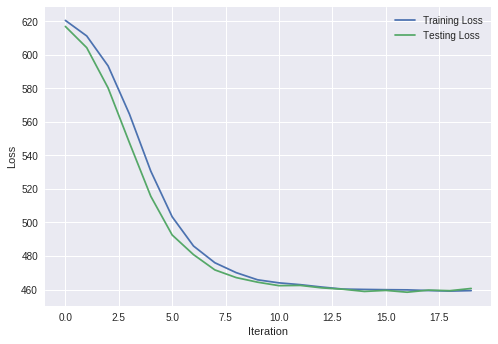

train_test_loss_losstype: softmax, optimadadelta, non_lintanh
Train Epoch: 0 [0/50000 (0%)]	 Loss 623.385986
Train Epoch: 0 [10000/50000 (20%)]	 Loss 623.196594
Train Epoch: 0 [20000/50000 (40%)]	 Loss 622.290161
Train Epoch: 0 [30000/50000 (60%)]	 Loss 621.808044
Train Epoch: 0 [40000/50000 (80%)]	 Loss 622.196045
Accuracy of model on test set 9.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 622.329407
Train Epoch: 1 [10000/50000 (20%)]	 Loss 619.787109
Train Epoch: 1 [20000/50000 (40%)]	 Loss 619.454712
Train Epoch: 1 [30000/50000 (60%)]	 Loss 618.763855
Train Epoch: 1 [40000/50000 (80%)]	 Loss 618.835083
Accuracy of model on test set 11.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 618.211365
Train Epoch: 2 [10000/50000 (20%)]	 Loss 616.659119
Train Epoch: 2 [20000/50000 (40%)]	 Loss 616.188049
Train Epoch: 2 [30000/50000 (60%)]	 Loss 615.288635
Train Epoch: 2 [40000/50000 (80%)]	 Loss 614.241028
Accuracy of model on test set 11.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 613.167725
Train Epoch: 3 [100

In [0]:
# Model
n_hidden = [1024, 512]
l2 = 0
drop_p = 0.3
# Hyperparameters
loss_type_ = ['softmax', 'hinge']
optim_ = ['sgd', 'rmsprop', 'adam', 'adagrad', 'adadelta']
non_lin_ = ['tanh','relu', 'sigmoid']
lr = 0.001
epochs = 20
for l_t in loss_type_:
    for opt in optim_:
        for nlin in non_lin_:
            model = MLP(n_in, n_hidden, drop_p, n_out, nlin)
            modeleval = ModelEvaluator(model, epochs, lr, loss_type=l_t, l2=l2, use_gpu=True, optim=opt)
            acc_ = modeleval.evaluator(trainloader, testloader, print_every=100, validation=False)
            modelname = 'model_loss_{}_optimizer_{}_nonlin_{}'.format(l_t, opt, nlin)
            print('Accuracy of {0} is {1:.2f}'.format(modelname, acc_))
            modeleval.plot_loss()
            torch.save(modeleval.model.state_dict(), modelname)
            print('train_test_loss_losstype: {0}, optim{1}, non_lin{2}'.format(l_t, opt, nlin))
            #plt.savefig('train_test_loss_losstype: {0}, optim{1}, non_lin{2}'.format(l_t, opt, nlin))
            #plt.show()

## Best Model

Nonlinearitity relu, Loss softmax, optimizer Adam